#Relatório 2



## Alterando o tipo de ambiente no Google Colab para Julia

In [21]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

versioninfo()

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


##Importando todas as bibliotecas necessárias para o exercício

In [125]:
using Plots, DSP, LinearAlgebra, LaTeXStrings, FFTW
gr();

## 1. (a) Filtro com método dos mínimos quadrados: janela retangular

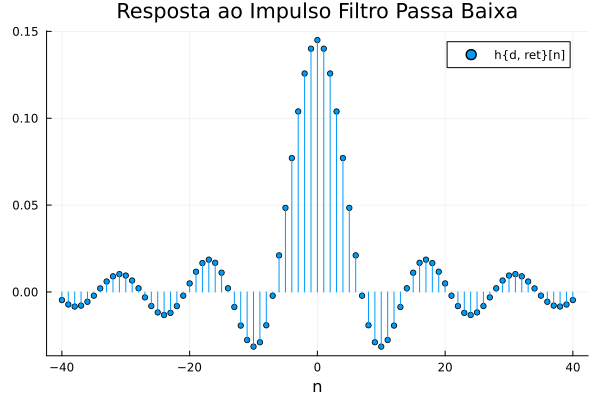

In [162]:
N = 81 
L = (N-1)/2
n = -L : L
wc = 29π/200

function passaBaixa(n, wc)
    hd = (wc/π) * sinc.((wc/π)*n)
    return hd
end

h = passaBaixa(n, wc)

plot(n, h, line = :stem, marker = (:circle, 3), xlabel = "n",
     label = "h{d, ret}[n]", title = "Resposta ao Impulso Filtro Passa Baixa")

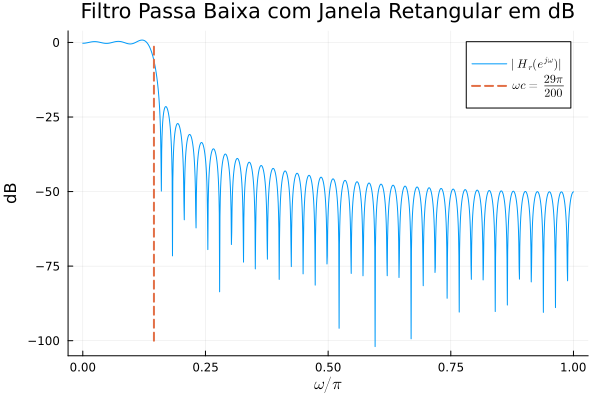

In [160]:
omega = range(0, π, length = 1500)
hrf = PolynomialRatio(h, [1])
Hr = freqresp(hrf, omega)

plot(omega/π, 20log10.(abs.(Hr)), ylabel = "dB", label = L"|H_r(e^{j\omega})|",
     xlabel = L"\omega/\pi", title = "Filtro Passa Baixa com Janela Retangular em dB")
plot!([wc,wc]/π, [-100,0], lw = 2, label = L"ωc = \frac{29\pi}{200}", linestyle= :dash)

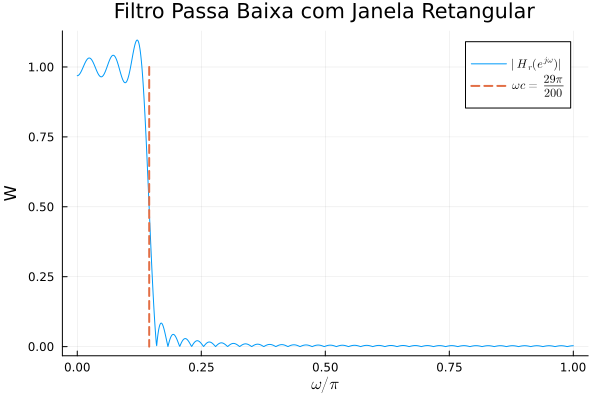

In [161]:
plot(omega/π, abs.(Hr), ylabel = "W", label = L"|H_r(e^{j\omega})|",
     xlabel = L"\omega/\pi", title = "Filtro Passa Baixa com Janela Retangular")
plot!([wc,wc]/π, [1,0], lw = 2, label = L"ωc = \frac{29\pi}{200}", linestyle= :dash)

## 1. (b) Filtro com método dos mínimos quadrados: janela retangular

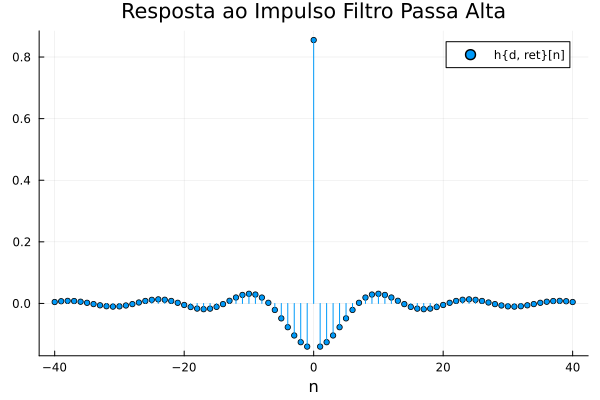

In [163]:
N = 81 
L = (N-1)/2
n = -L : L
wc = 29π/200

function passaAlta(n, wc)
    hd = -(wc/π) * sinc.((wc/π)*n)
    hd[(length(n)+1) ÷ 2] += 1  # Adicionar 1 ao valor central para compensar o sinal negativo
    return hd
end

h = passaAlta(n, wc)

plot(n, h, line = :stem, marker = (:circle, 3), xlabel = "n",
     label = "h{d, ret}[n]", title = "Resposta ao Impulso Filtro Passa Alta")

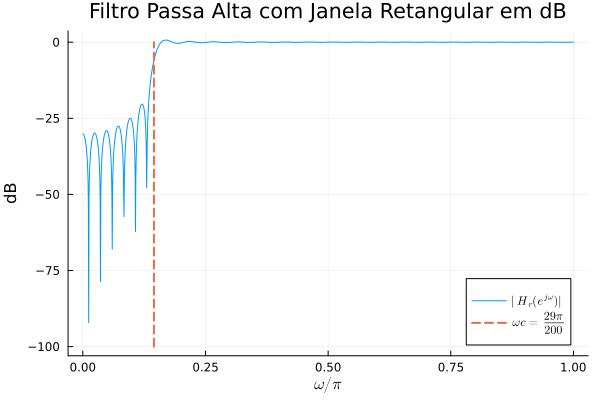

In [166]:
omega = range(0, π, length = 1500)
hrf = PolynomialRatio(h, [1])
Hr = freqresp(hrf, omega)

plot(omega/π, 20log10.(abs.(Hr)), ylabel = "dB", label = L"|H_r(e^{j\omega})|",
     xlabel = L"\omega/\pi", title = "Filtro Passa Alta com Janela Retangular em dB")
plot!([wc,wc]/π, [-100,0], lw = 2, label = L"ωc = \frac{29\pi}{200}", linestyle= :dash)

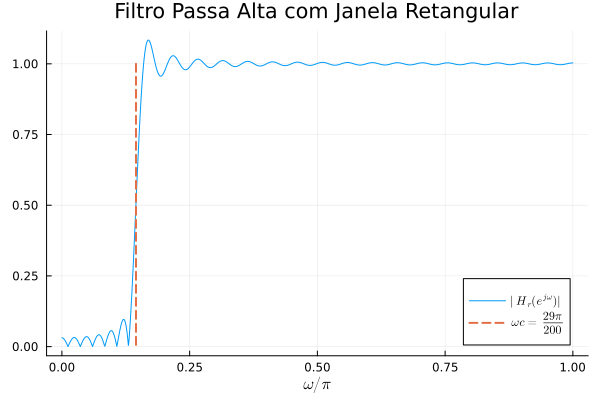

In [167]:
plot(omega/π, abs.(Hr), label = L"|H_r(e^{j\omega})|",
     xlabel = L"\omega/\pi", title = "Filtro Passa Alta com Janela Retangular")
plot!([wc,wc]/π, [1,0], lw = 2, label = L"ωc = \frac{29\pi}{200}", linestyle= :dash)

## 2. Filtro: y[n] = h[0]x[n] + h[1]x[n − 1] + . . . h[N − 1]x[n − N + 1].

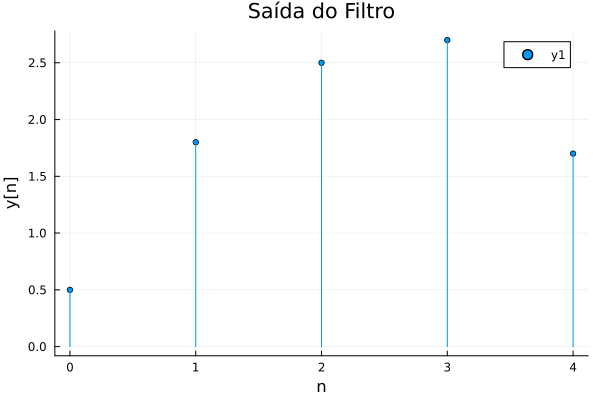

In [308]:
function filtro_FIR(x, h)
    K = length(x)
    N = length(h)
    y = zeros(K)

    for n = 0:K-1
        for k = 0:N-1
            if n-k >= 0
                y[n+1] += h[k+1] * x[n-k+1] # Aplica a convolução
            end
        end
    end

    return y
end

x = [1, 3, 3, 3, 1]  # Amostras do sinal de entrada
h = [0.5, 0.3, 0.1]  # Coeficientes do filtro

y = filtro_FIR(x, h)  # Chama a função filtro_FIR
n = 0:length(y)-1

plot(n, y, line = :stem, marker = (:circle, 3), xlabel = "n",
    ylabel = "y[n]", title = "Saída do Filtro")

## 3. (a) Testar o filtro com a entrada x[n] = cos(πn/25) + cos(πn/4).

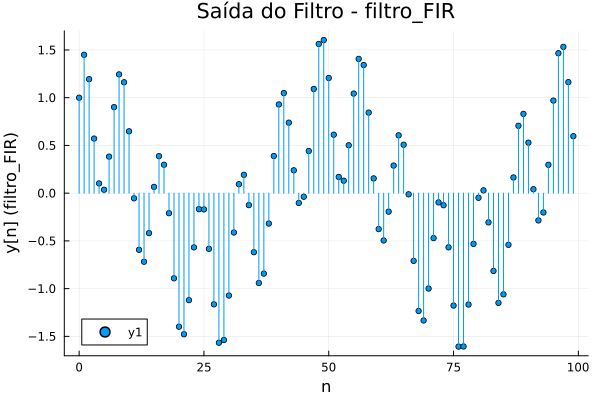

In [309]:
x = [cos(π*n/25) + cos(π*n/4) for n in 0:99]  # Amostras do sinal de entrada

y_proprio = filtro_FIR(x, h)  # Saída do filtro usando o programa implementado

# Plot da saída do filtro usando o programa implementado
n = 0:length(y_proprio)-1
plot(n, y_proprio, line = :stem, marker = (:circle, 3), xlabel = "n",
     ylabel = "y[n] (filtro_FIR)", title = "Saída do Filtro - filtro_FIR")

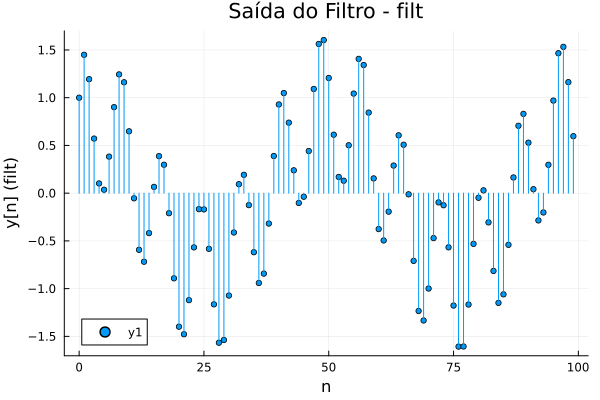

In [310]:
y_filt = filt(h, 1, x)  # Saída do filtro usando o comando filt do Julia

# Plot da saída do filtro usando o comando filt do Julia
plot(n, y_filt, line = :stem, marker = (:circle, 3), xlabel = "n",
     ylabel = "y[n] (filt)", title = "Saída do Filtro - filt")

3. (b) Desenhe a resposta em frequência (módulo e fase) do filtro

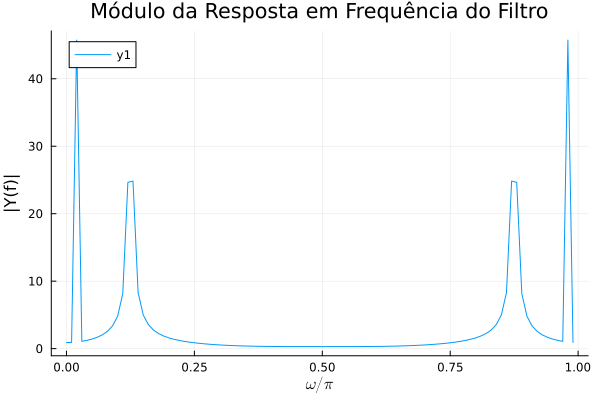

In [227]:
# Cálculo da resposta em frequência
h = [0.5, 0.3, 0.1, zeros(97)...]

X = fft(x)
H = fft(h)
Y = X .* H

f = 0:1/length(Y):1-1/length(Y)  # Frequências correspondentes

Y_mag = abs.(Y)  # Módulo da resposta em frequência
plot(f, Y_mag, xlabel = L"\omega/\pi", ylabel = "|Y(f)|",
    title = "Módulo da Resposta em Frequência do Filtro")

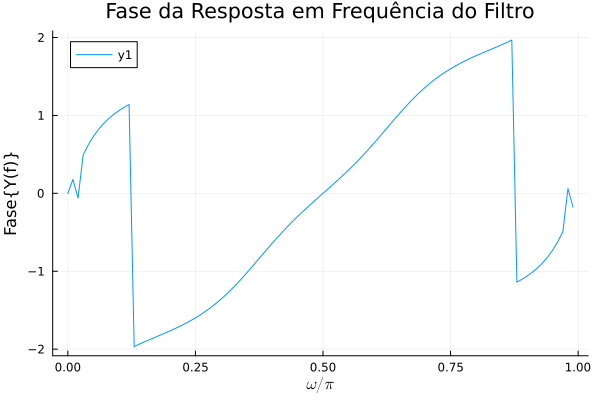

In [228]:
Y_arg = angle.(Y)
plot(f, Y_arg, xlabel = L"\omega/\pi", ylabel = "Fase{Y(f)}",
    title = "Fase da Resposta em Frequência do Filtro")

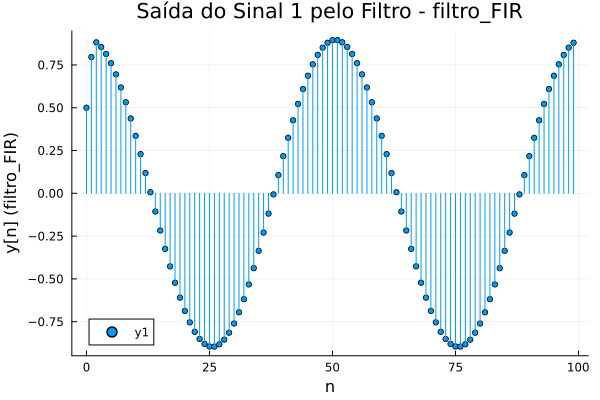

In [235]:
x1 = [cos(π*n/25) for n in 0:99]  # Sinal x1[n]
y1 = filtro_FIR(x1, h)  # Saída do filtro para x1[n]

n = 0:length(y1)-1
plot(n, y1, line = :stem, marker = (:circle, 3), xlabel = "n",
     ylabel = "y[n] (filtro_FIR)", title = "Saída do Sinal 1 pelo Filtro - filtro_FIR")

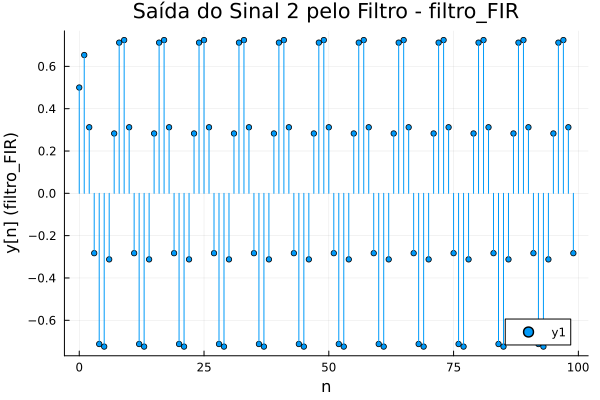

In [236]:
x2 = [cos(π*n/4) for n in 0:99]  # Sinal x2[n]
y2 = filtro_FIR(x2, h)  # Saída do filtro para x2[n]

n = 0:length(y2)-1
plot(n, y2, line = :stem, marker = (:circle, 3), xlabel = "n",
     ylabel = "y[n] (filtro_FIR)", title = "Saída do Sinal 2 pelo Filtro - filtro_FIR")

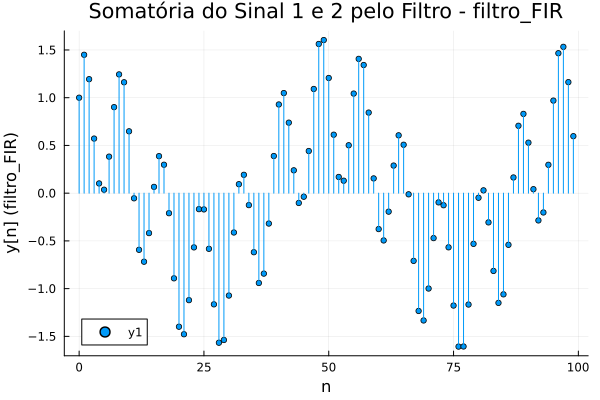

In [243]:
n = 0:length(y2+y1)-1
plot(n, y2+y1, line = :stem, marker = (:circle, 3), xlabel = "n",
     ylabel = "y[n] (filtro_FIR)", title = "Somatória do Sinal 1 e 2 pelo Filtro - filtro_FIR")

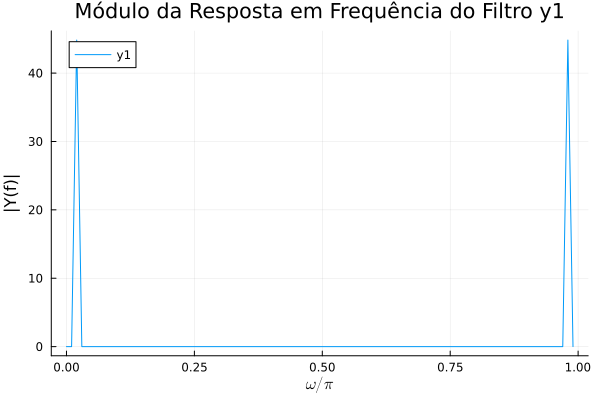

In [241]:
h = [0.5, 0.3, 0.1, zeros(97)...]

X = fft(x1)
H = fft(h)
Y = X .* H

f = 0:1/length(Y):1-1/length(Y)  # Frequências correspondentes

Y_mag = abs.(Y)  # Módulo da resposta em frequência
plot(f, Y_mag, xlabel = L"\omega/\pi", ylabel = "|Y(f)|",
    title = "Módulo da Resposta em Frequência do Filtro y1")

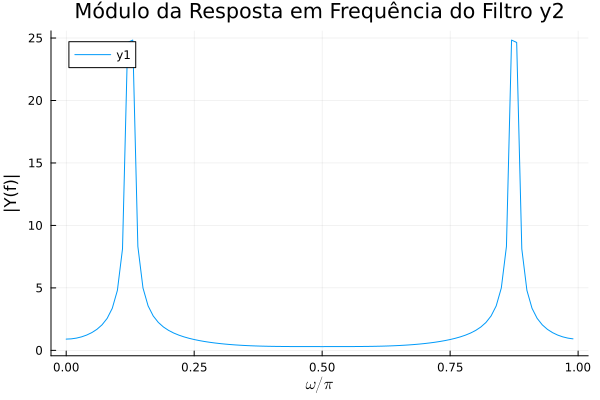

In [242]:
h = [0.5, 0.3, 0.1, zeros(97)...]

X = fft(x2)
H = fft(h)
Y = X .* H

f = 0:1/length(Y):1-1/length(Y)  # Frequências correspondentes

Y_mag = abs.(Y)  # Módulo da resposta em frequência
plot(f, Y_mag, xlabel = L"\omega/\pi", ylabel = "|Y(f)|",
    title = "Módulo da Resposta em Frequência do Filtro y2")

## 4. Janela Kaiser

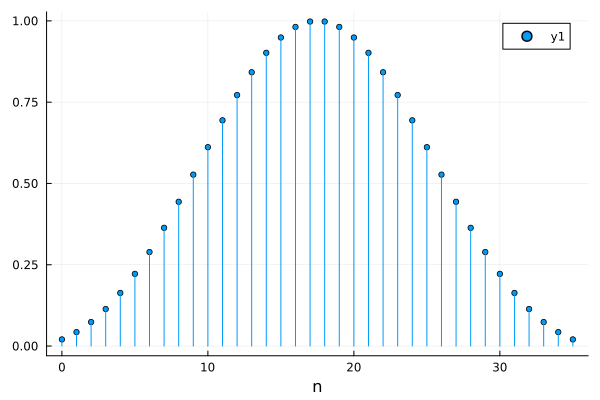

In [289]:
const Fs = 1000  # Frequência de amostragem
const T = 1/Fs  # Período de amostragem

const ωp_pb = π/25  # Frequência de passagem para o filtro passa-baixas
const ωr_pb = π/4  # Frequência de rejeição para o filtro passa-baixas

const ωp_pa = π/4  # Frequência de passagem para o filtro passa-altas
const ωr_pa = π/25  # Frequência de rejeição para o filtro passa-altas

const dp = 0.005
const dr = 0.001

"""
 filtrokaiser(ωp, ωr, δp, δr)
 Projeta filtro FIR com janela de Kaiser.
 Se `ωp > ωr`, o filtro projetado é passa-altas tipo I.
"""

function filtrokaiser(ωp, ωr, dp, dr)
  A = -20log10(min(dp, dr))
  N = ceil(Int, (A-8)/(2.285*abs(ωr-ωp)) + 1)
  if ωp > ωr && mod(N, 2) == 0
    N += 1
  end
  if A < 21
    beta = 0
  elseif A <= 50
    beta = 0.5842(A-21)^0.4 + 0.07886(A-21)
  else
    beta = 0.1102(A-8.7)
  end
  fc = (ωp + ωr)/(2π)
  L = (N-1)/2
  n = 0:N-1
  h = fc * sinc.(fc * (n .- L)) .* kaiser(N, beta/pi)
  if ωp > ωr
    h .= -h
    h[Int(L)+1] += 1.0
  end
  return h, beta, N
end

(h, beta, Nk) = filtrokaiser(ωp_pb, ωr_pb, dp, dr)

nk = 0:Nk-1
wk = kaiser(Nk, beta/pi)
plot(nk, wk, line = :stem, marker = (:circle, 3), xlabel = "n")

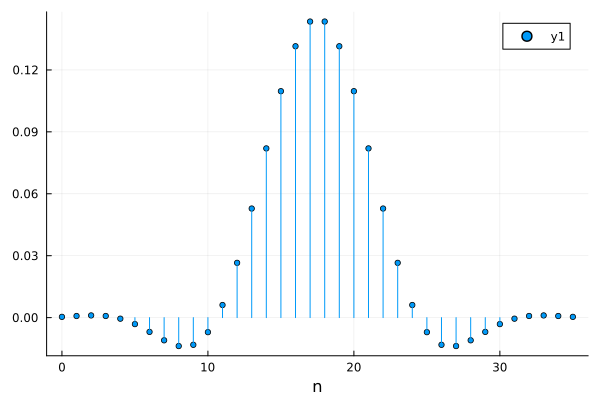

In [290]:
Lk = (Nk - 1) / 2
plot(nk, h, line = :stem, marker = (:circle, 3), xlabel = "n")

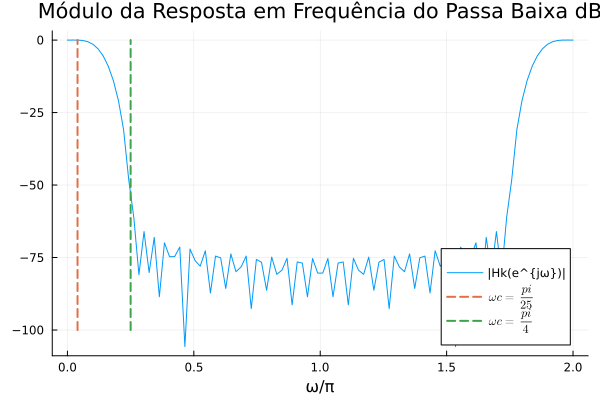

In [295]:
hkf = PolynomialRatio(h, [1])
Hk = freqresp(hkf, ω)
plot(ω/π, 20log10.(abs.(Hk)), label = "|Hk(e^{jω})|",
     xlabel = "ω/π", title = "Módulo da Resposta em Frequência do Passa Baixa dB")
plot!([pi/25,pi/25]/π, [-100,0], lw = 2, label = L"ωc = \frac{pi}{25}", linestyle= :dash)
plot!([pi/4,pi/4]/π, [-100,0], lw = 2, label = L"ωc = \frac{pi}{4}", linestyle= :dash)

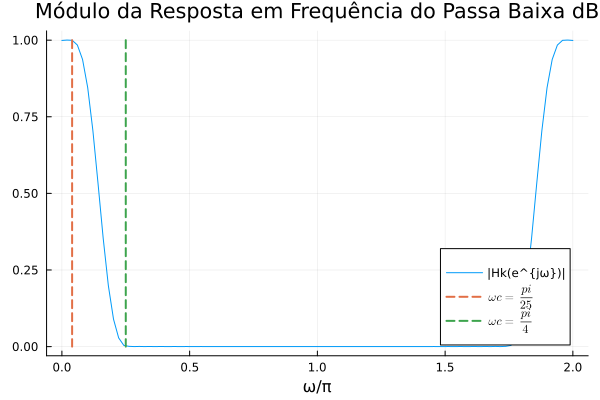

In [294]:
plot(ω/π, abs.(Hk), label = "|Hk(e^{jω})|",
     xlabel = "ω/π", title = "Módulo da Resposta em Frequência do Passa Baixa dB")
plot!([pi/25,pi/25]/π, [1,0], lw = 2, label = L"ωc = \frac{pi}{25}", linestyle= :dash)
plot!([pi/4,pi/4]/π, [1,0], lw = 2, label = L"ωc = \frac{pi}{4}", linestyle= :dash)

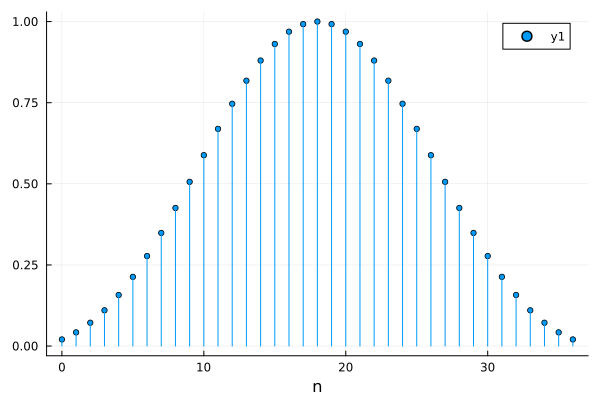

In [312]:
(h, beta, Nk) = filtrokaiser(ωp_pa, ωr_pa, dp, dr)

nk = 0:Nk-1
wk = kaiser(Nk, beta/pi)
plot(nk, wk, line = :stem, marker = (:circle, 3), xlabel = "n")

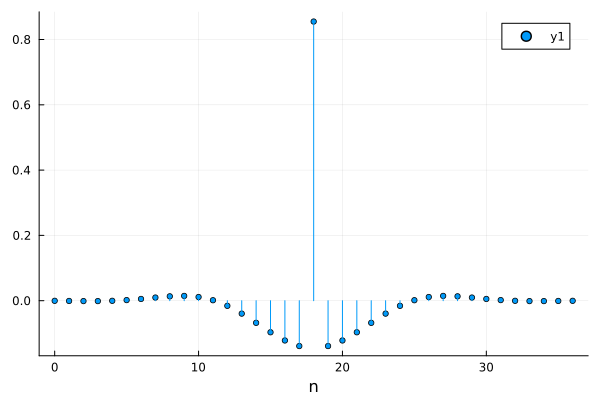

In [297]:
Lk = (Nk - 1) / 2
plot(nk, h, line = :stem, marker = (:circle, 3), xlabel = "n")

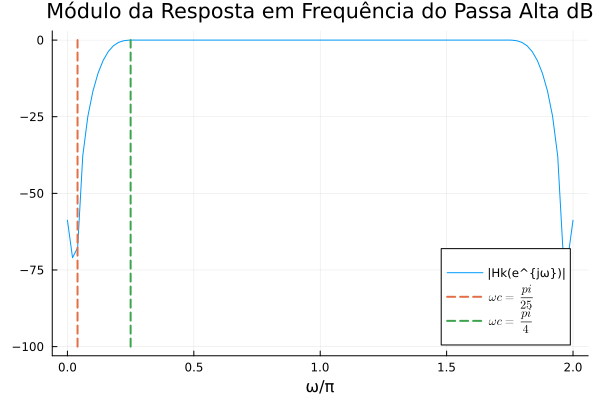

In [299]:
hkf = PolynomialRatio(h, [1])
Hk = freqresp(hkf, ω)
plot(ω/π, 20log10.(abs.(Hk)), label = "|Hk(e^{jω})|",
     xlabel = "ω/π", title = "Módulo da Resposta em Frequência do Passa Alta dB")
plot!([pi/25,pi/25]/π, [-100,0], lw = 2, label = L"ωc = \frac{pi}{25}", linestyle= :dash)
plot!([pi/4,pi/4]/π, [-100,0], lw = 2, label = L"ωc = \frac{pi}{4}", linestyle= :dash)

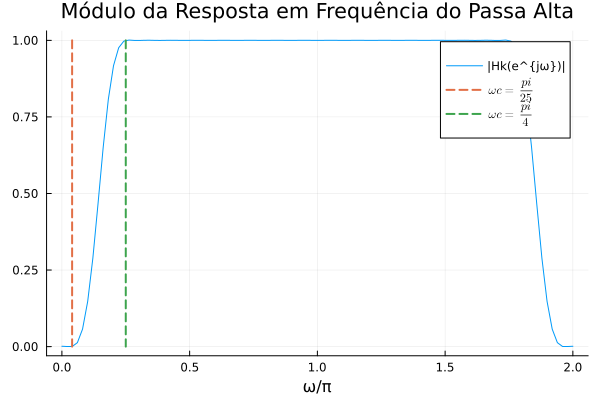

In [300]:
plot(ω/π, abs.(Hk), label = "|Hk(e^{jω})|",
     xlabel = "ω/π", title = "Módulo da Resposta em Frequência do Passa Alta")
plot!([pi/25,pi/25]/π, [1,0], lw = 2, label = L"ωc = \frac{pi}{25}", linestyle= :dash)
plot!([pi/4,pi/4]/π, [1,0], lw = 2, label = L"ωc = \frac{pi}{4}", linestyle= :dash)

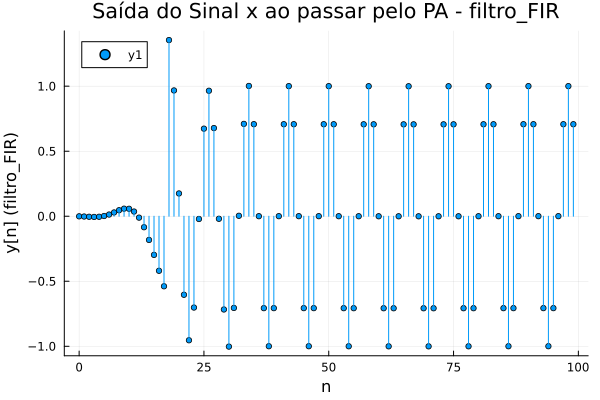

In [316]:
(h, beta, Nk) = filtrokaiser(ωp_pa, ωr_pa, dp, dr) # Passa Alta
Y = filtro_FIR(x, h)  # Saída do filtro para x2[n]

n = 0:length(Y)-1
plot(n, Y, line = :stem, marker = (:circle, 3), xlabel = "n",
     ylabel = "y[n] (filtro_FIR)", title = "Saída do Sinal x ao passar pelo PA - filtro_FIR")

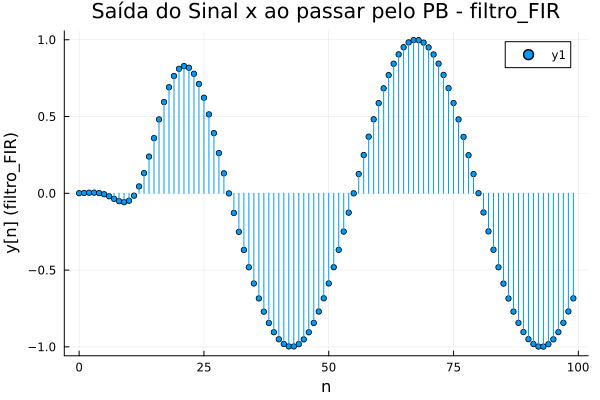

In [317]:
(h, beta, Nk) = filtrokaiser(ωp_pb, ωr_pb, dp, dr) # Passa Baixa
Y = filtro_FIR(x, h)  # Saída do filtro para x2[n]

n = 0:length(Y)-1
plot(n, Y, line = :stem, marker = (:circle, 3), xlabel = "n",
     ylabel = "y[n] (filtro_FIR)", title = "Saída do Sinal x ao passar pelo PB - filtro_FIR")

## 5. Usando o método min-max de projeto (algoritmo de ParksMcClellan)

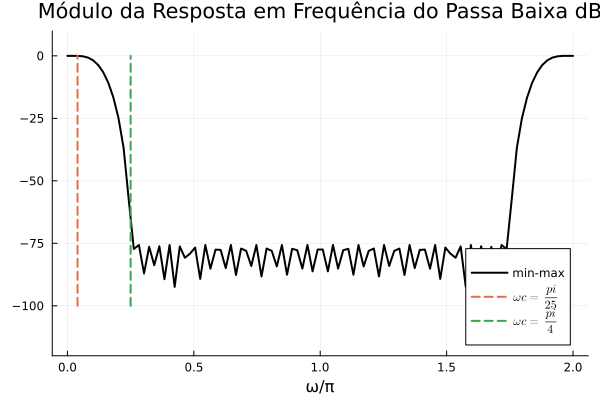

In [331]:
const Fs = 1000  # Frequência de amostragem
const T = 1/Fs  # Período de amostragem

const ωp_pb = π/25  # Frequência de passagem para o filtro passa-baixas
const ωr_pb = π/4  # Frequência de rejeição para o filtro passa-baixas

wd = (ωp_pb + ωr_pb)/2

const ωp_pa = π/4  # Frequência de passagem para o filtro passa-altas
const ωr_pa = π/25  # Frequência de rejeição para o filtro passa-altas

const dp = 0.005
const dr = 0.001

Nmm = ceil(Int, (-10log10(dp*dr)-13) / (2.324*wd)) + 2 # A fórmula básica soma  # estou somando 2 para # sejam atendidas

hmm = remez(Nmm-1, [(0, ωp_pb/pi) => (1, 1), (ωr_pb/pi, 1) => (0, dp/dr)]; Hz = 2)
hpbmmf = PolynomialRatio(hmm, [1])
Hpbmm = freqresp(hpbmmf, ω)

plot(ω/pi, amp2db.(abs.(Hpbmm)), label = "min-max",
      xlabel = "ω/π", ylims = (-120, 10),
      lw = 2, color = :black, title = "Módulo da Resposta em Frequência do Passa Baixa dB")
plot!([pi/25,pi/25]/π, [-100,0], lw = 2, label = L"ωc = \frac{pi}{25}", linestyle= :dash)
plot!([pi/4,pi/4]/π, [-100,0], lw = 2, label = L"ωc = \frac{pi}{4}", linestyle= :dash)